# Marketing Analytics
#### Gianmaria Carnazzi, Giulio Mantoan, Giacomo Miolo, Mireia Riviere, Paolo Ticozzi

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

In [65]:
PATH = "/Users/giacomomiolo/Downloads/Marketing analytics/Exam/"
df = pd.read_excel(PATH + "BABD_DB for group assignment_CRM.xlsx", sheet_name="Business Game")

In [66]:
import re
from functools import wraps

def print_return_type(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            result = func(*args, **kwargs)
        finally:
            print(f'Function {func.__name__} returned type {type(result)}.')
            return result
    return wrapper

def clean_str(string):
    '''
    Removes special characters and double spaces from a string, preserving single spaces between words.
    
    Args:
        string (str): the dirty string to clean.
    
    Returns:
        cleaned (str)
    '''
    non_word_digit = re.compile(r"[^a-zA-Z0-9 ]+") # Leaving spaces, removing all non letter/digit (add \- to leave - char as well)
    multiple_spaces = re.compile(r"( {1,})") # Catching all repeated spaces
    start_end_spaces = re.compile(r"(\A\s|\s\Z)") # Removing spaces at start/end
    step_1 = re.sub(non_word_digit, "", string)
    step_2 = re.sub(multiple_spaces, "_", step_1)
    cleaned = re.sub(start_end_spaces, "", step_2)
    
    return cleaned

def describe_col(df, col):
    
    '''Takes as input a dataframe and the name of the column you want to describe.
    Returns the unique values, eventual missing values count,
    the absolute frequencies and the relative frequencies of unique values.'''
    
    # Number, count and percentage of unique values in the column
    print(f'{col} - {df[col].nunique()} unique values.')
    count = df[col].value_counts(sort=True, dropna=True)
    perc = df[col].value_counts(normalize=True, sort=True, ascending=False, dropna=True)*100
    d = pd.concat([perc, count], axis=1, keys=['Percentage %', 'Count'])
    
    # dtype of the column
    print(f"dtype: {df[col].dtype}.")
    
    # Number of missing values, if any
    missing_count = df[col].isnull().sum()
    if missing_count != 0:
        total = len(df[col])
        missing_perc = (missing_count/total)*100
        
        print(f'! Missing values: perc - {missing_perc:0.3f}% count - {missing_count}')
    else:
        print(f'No missing values.\n')
    

    return print(d)



def num2quantile(df, col, num1, num2='<', ID='ID', verbose=False):
    '''
    Returns the corresponding quantile of a numeric value of a column.
    '''
    
    if type(num2) == str:
        if num2 == '<':
            quant = df.loc[df[col] < num1, ID].count() / df.shape[0] * 100
        elif num2 == '>':
            quant = df.loc[df[col] > num1, ID].count() / df.shape[0] * 100
    else:
        quant = df.loc[(df[col]>=num1) & (df[col]<num2), ID].count() / df.shape[0] * 100
    if verbose:
        print(f'{quant:0.2f}%')
    return quant


def ranges(input_df, col, name, tuples, last):
    '''
    Creates a new column with labels of the corresponding range
    
    Args:
        input_df (pandas.core.frame.DataFrame): Dataframe to modify.
        col (str): Column with numeric values to use to create ranges.
        name (str): Name of the column to be created with the labels.
        tuples (list): List of tuples with values and labels. Ex. [(100, 'Low'), (400, 'Medium')]
    '''
    df = input_df.copy()
    counter = 0
    df[name] = last
    df['Order'] = len(tuples)+1
    for i in range(len(tuples)):
        if i == 0:
            #print(f"{tuples[i][0]} - {tuples[i][1]}")
            df.loc[df[col] < tuples[i][0], name] = tuples[i][1]
            df.loc[df[col] < tuples[i][0], 'Order'] = i
        else:
            #print(f"{tuples[i][0]} - {tuples[i][1]}")
            df.loc[(df[col] >= tuples[i-1][0]) & (df[col] < tuples[i][0]), name] = tuples[i][1]
            df.loc[(df[col] >= tuples[i-1][0]) & (df[col] < tuples[i][0]), 'Order'] = i
    return df



def n_outl(df, col_name, method='norm', n_std=2, detect=False):
    '''
    df (pandas.core.frame.DataFrame): Dataframe.
    col_name (str): Numeric column to be consider.
    method (str, optional): Accepts 'IQR' for interquartile range, defaults to Normal Distribution.
    n_std (int, optional): Number of standard deviations to consider, defaults to 2.
    '''
    if method.lower()=='norm':
        mean = df[col_name].mean()
        sd = df[col_name].std()
        
        # keep only the ones that are within +x to -x standard deviations in the column
        boolean_mask = (np.abs(df[col_name].values - mean) > n_std*sd)
        

    elif method.lower()=='iqr':
    
        q1 = np.quantile(df[col_name], 0.25)
        q3 = np.quantile(df[col_name], 0.75)
        iqr = q3-q1
        th1 = q1 - 1.5*iqr
        th3 = q3 + 1.5*iqr

        boolean_mask = ( (df[col_name] > th3) | (df[col_name] < th1) ) 
    
    
    if detect:
        df_outliers = df[boolean_mask]
        return df_outliers

    outliers = len(df[boolean_mask])
    return outliers

def get_stats(df, group, inputs, order=False, outlier=True, n_std=2):
    '''
    df (pandas.core.frame.DataFrame): Dataframe containing all the columns of interest.
    group (str): Name of the column for which to group by.
    inputs (str, list): If list (max 2 elements), first element is the part, the second is the total.
    order(bool, optional): If there is a column to consider for ordering.
    outlier (bool, optional): Defaults to True, detects outliers.
    n_std (int, optional): Defaults to 2, number of standard deviations to classify outliers.
    '''

    if type(inputs) == list:
    	# Total
        col_tot = inputs[1]
        str_tot = col_tot.split("_")[-1]
        # Part
        col_stats = inputs[0]
        str_stats = col_stats.split("_")[-1]
    elif type(inputs) == str:
        col_stats = inputs
        str_stats = col_stats.split("_")[-1]

    stats = pd.DataFrame()
    stats['Percentage'] = np.round(df[group].value_counts(normalize = True, sort = True, ascending=False, dropna=True)*100, 2)
    stats['Count'] = df[group].value_counts(sort=True, dropna=True)
    stats.reset_index(inplace=True)
    stats.rename(columns={'index': group}, inplace=True)
    stats = stats.merge(df.groupby(group, as_index=False)[col_stats].min().rename(columns={col_stats: 'Sales_Min'}), on=group)
    stats = stats.merge(df.groupby(group, as_index=False)[col_stats].mean().rename(columns={col_stats: 'Sales_Average'}), on=group)
    stats = stats.merge(df.groupby(group, as_index=False)[col_stats].median().rename(columns={col_stats: 'Sales_Median'}), on=group)
    stats = stats.merge(df.groupby(group, as_index=False)[col_stats].max().rename(columns={col_stats: 'Sales_Max'}), on=group)
    stats = stats.merge(df.groupby(group, as_index=False)[col_stats].sum().rename(columns={col_stats: 'Sales_Total'}), on=group)
    
    stats['Sales_Perc_of_' + str_stats] = stats['Sales_Total'] / np.sum(stats['Sales_Total'])

    if type(inputs) == list:

        stats['Sales_Perc_of_' + str_tot] = stats['Sales_Total'] / np.sum(df[col_tot])
        stats['Sales_Perc_of_' + str_tot] = np.round(stats['Sales_Perc_of_' + str_tot] * 100, 2)

   

    if outlier:
        d = {}
        for i in [*stats[group]]:
            this_mask = df[group] == i
            n = n_outl(df[this_mask], col_stats, n_std=n_std)
            d[i] = n
        
        d_df = pd.DataFrame.from_dict(d, orient='index')
        d_df.reset_index(inplace=True)
        d_df.columns = [group, 'Outlier_Count']
        stats = stats.merge(d_df, on=group)
        stats['Outlier_Perc'] = np.round(stats['Outlier_Count'] / stats['Count'] * 100, 2)

    if order:
        # Ordering
        stats = stats.merge(df.loc[:,[group, 'Order']].drop_duplicates(), on=group).sort_values('Order', ascending=True)
        stats.set_index('Order', inplace=True)
        stats.index.rename('', inplace=True)
    
    # Formatting
    
    stats['Sales_Min'] = stats['Sales_Min'].astype(int)
    stats['Sales_Average'] = stats['Sales_Average'].astype(int)
    stats['Sales_Median'] = stats['Sales_Median'].astype(int)
    stats['Sales_Max'] = stats['Sales_Max'].astype(int)
    stats['Sales_Total'] = stats['Sales_Total'].astype(int)
    stats['Sales_Perc_of_' + str_stats] = np.round(stats['Sales_Perc_of_' + str_stats] * 100, 2)
    
    return stats

In [67]:
new_cols = ['ID',
 'Channel_2017',
 'Sales_2017_Total_Omnichannel',
 'Sales_2017_in_Store',
 'Sales_2017_Online',
 'Sales_2018_Total_Omnichannel',
 'Loyalty_Status_2017_in_Store',
 'Loyalty_Status_2017_Online',
 'Loyalty_Status_2017_Total_Omnichannel',
 'Loyalty_Status_2018_Total_Omnichannel',
 'Country_Store',
 'Country_Customer',
 'Complaint',
 'Complaint_Channel',
 'Complaint_Reason']
df.columns = new_cols

In [68]:
pd.DataFrame([df.isna().sum().values,
              np.round(df.isna().sum().values/len(df)*100,0)], index=['Count','Percentage'], columns=df.columns).T

,Count,Percentage
ID,0.0,0.0
Channel_2017,0.0,0.0
Sales_2017_Total_Omnichannel,0.0,0.0
Sales_2017_in_Store,7953.0,16.0
Sales_2017_Online,30794.0,63.0
Sales_2018_Total_Omnichannel,36541.0,75.0
Loyalty_Status_2017_in_Store,7953.0,16.0
Loyalty_Status_2017_Online,30794.0,63.0
Loyalty_Status_2017_Total_Omnichannel,0.0,0.0
Loyalty_Status_2018_Total_Omnichannel,0.0,0.0


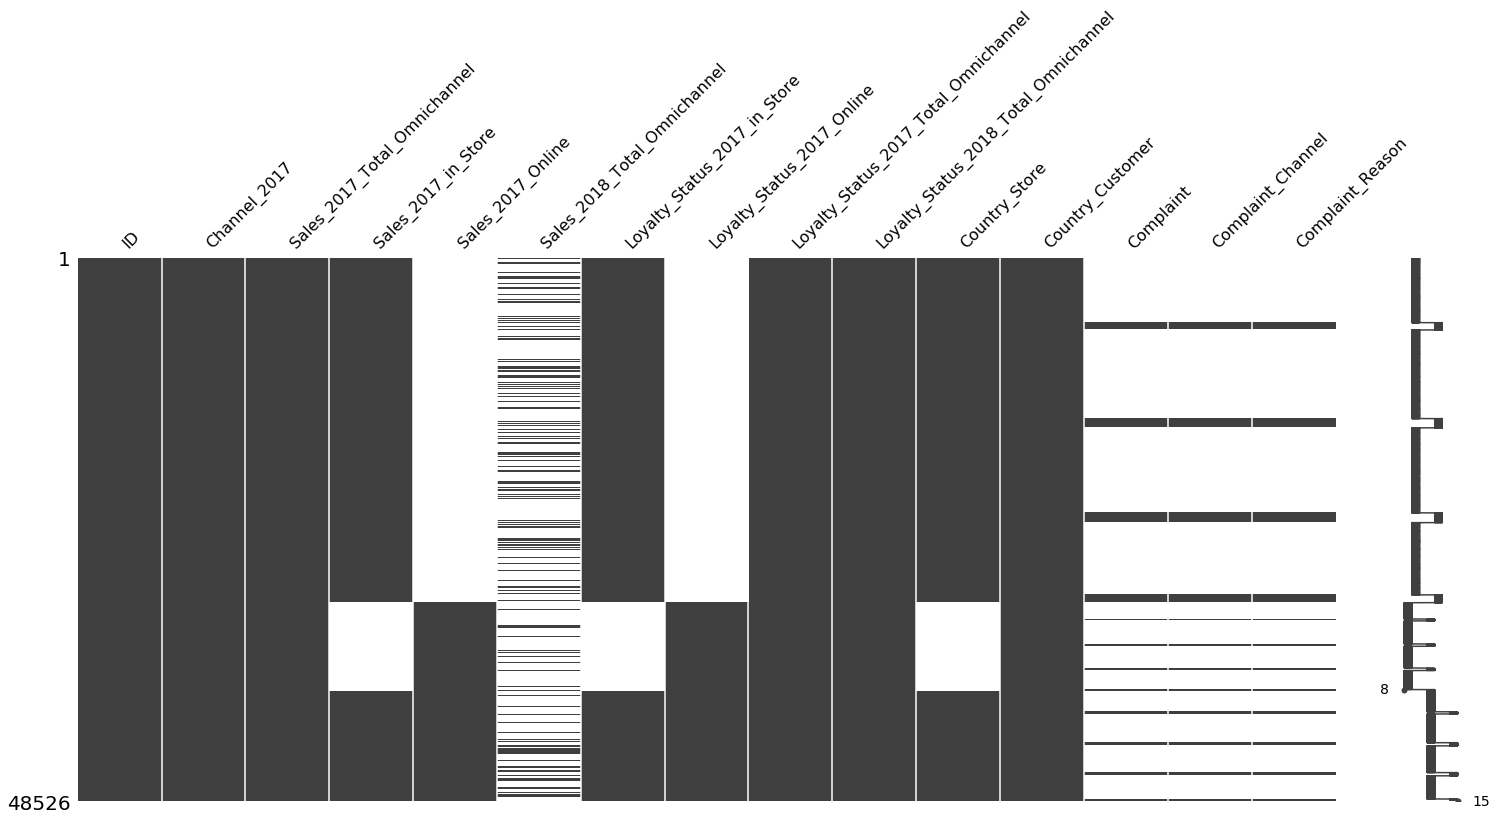

In [69]:
msno.matrix(df)
plt.show()

In [70]:
print("Number of records:",df.shape[0],"\n"+
      "Number of unique customer ID:",df.ID.unique().shape[0]
     )

Number of records: 48526 
Number of unique customer ID: 48526


As many records as customer ID. Under the hypothesis that a customer ID belongs to one person, there're no duplicates in the dataset.

### Addding Domestic Foreign Column (valid only for stores)

In [71]:
describe_col(df, 'Channel_2017')

Channel_2017 - 3 unique values.
dtype: object.
No missing values.

        Percentage %  Count
Store      63.458764  30794
Both       20.152083   9779
Online     16.389152   7953


In [72]:
domestic_mask = df['Country_Store'] == df['Country_Customer']
df['Domestic_Foreign'] = domestic_mask
df['Domestic_Foreign'].replace(to_replace=[True,False], value=['Domestic','Foreign'], inplace=True)

In [73]:
df.loc[df['Channel_2017'] == 'Online', 'Domestic_Foreign'] = np.nan

### Exploratory Data Analysis

In [74]:
describe_col(df,'Loyalty_Status_2017_Total_Omnichannel')

Loyalty_Status_2017_Total_Omnichannel - 2 unique values.
dtype: object.
No missing values.

       Percentage %  Count
New       50.471912  24492
Loyal     49.528088  24034


In [75]:
describe_col(df,'Country_Customer')

Country_Customer - 8 unique values.
dtype: object.
No missing values.

         Percentage %  Count
China       20.593084   9993
US          18.833203   9139
Russia      15.639039   7589
UK          12.698347   6162
Italy        9.889544   4799
France       9.854511   4782
Germany      8.335738   4045
Japan        4.156535   2017


In [76]:
describe_col(df, 'Country_Store')

Country_Store - 4 unique values.
dtype: object.
! Missing values: perc - 16.389% count - 7953
        Percentage %  Count
France     28.543613  11581
Italy      27.464077  11143
US         23.205087   9415
China      20.787223   8434


### Segmentation 2017 Omnichannel

In [77]:
spending = [80, 200, 600, 2000, 10000]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
last_label = 'Top Clients'
tuples = [*zip(spending, labels)]
asc_labels = labels+[last_label]
desc_labels = [asc_labels[i] for i in range(len(asc_labels)-1,-1,-1)]

df_omni = ranges(df[df['Sales_2017_Total_Omnichannel'].notna()], 'Sales_2017_Total_Omnichannel', 'Spending_Ranges_2017', tuples, last_label)
stats_omni = get_stats(df_omni, 'Spending_Ranges_2017', 'Sales_2017_Total_Omnichannel', n_std=3)
stats_omni

,Spending_Ranges_2017,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Omnichannel,Outlier_Count,Outlier_Perc
0,Medium,35.73,17339,200,368,358,599,6384993,14.66,0,0.00
1,Low,21.26,10315,80,133,129,199,1379594,3.17,0,0.00
2,High,20.89,10136,600,1068,974,1999,10832814,24.87,0,0.00
3,Very Low,12.79,6205,5,54,57,79,340155,0.78,0,0.00
4,Very High,8.19,3974,2000,3814,3111,9993,15157139,34.79,40,1.01
5,Top Clients,1.15,557,10013,16997,13833,81450,9467369,21.73,15,2.69


#### Outliers of Top Clients - Omnichannel

In [78]:
stellar_clients_omni = n_outl(df_omni[df_omni["Spending_Ranges_2017"]=="Top Clients"], 'Sales_2017_Total_Omnichannel', n_std=3, detect=True)
print(f"Number of most important clients: {stellar_clients_omni.shape[0]}")
print(f"In 2018, {stellar_clients_omni[stellar_clients_omni['Loyalty_Status_2018_Total_Omnichannel'] == 'Lost'].shape[0]} of them were lost.")
stellar_clients_omni

Number of most important clients: 15
In 2018, 10 of them were lost.


,ID,Channel_2017,Sales_2017_Total_Omnichannel,Sales_2017_in_Store,Sales_2017_Online,Sales_2018_Total_Omnichannel,Loyalty_Status_2017_in_Store,Loyalty_Status_2017_Online,Loyalty_Status_2017_Total_Omnichannel,Loyalty_Status_2018_Total_Omnichannel,Country_Store,Country_Customer,Complaint,Complaint_Channel,Complaint_Reason,Domestic_Foreign,Spending_Ranges_2017,Order
5797,60002003119,Store,52603.9625,52603.9625,NaN,NaN,Loyal,NaN,Loyal,Lost,China,Italy,NaN,NaN,NaN,Foreign,Top Clients,6
5798,68002002362,Store,55405.4200,55405.4200,NaN,89.0,New,NaN,New,Loyal,China,UK,NaN,NaN,NaN,Foreign,Top Clients,6
5799,68001005829,Store,55686.1050,55686.1050,NaN,298.0,Loyal,NaN,Loyal,Loyal,China,China,NaN,NaN,NaN,Domestic,Top Clients,6
5800,60001000833,Store,70225.6975,70225.6975,NaN,NaN,Loyal,NaN,Loyal,Lost,China,Russia,NaN,NaN,NaN,Foreign,Top Clients,6
14354,60002011391,Store,45713.1300,45713.1300,NaN,195.0,Loyal,NaN,Loyal,Loyal,France,China,NaN,NaN,NaN,Foreign,Top Clients,6
14355,68003004831,Store,57146.3925,57146.3925,NaN,NaN,Loyal,NaN,Loyal,Lost,France,France,NaN,NaN,NaN,Domestic,Top Clients,6
14356,999999094735,Store,63965.4525,63965.4525,NaN,449.0,Loyal,NaN,Loyal,Loyal,France,China,NaN,NaN,NaN,Foreign,Top Clients,6
14357,999999094823,Store,74290.5800,74290.5800,NaN,NaN,Loyal,NaN,Loyal,Lost,France,China,NaN,NaN,NaN,Foreign,Top Clients,6
14843,60001004447,Store,48889.0400,48889.0400,NaN,NaN,New,NaN,New,Lost,France,Russia,Complaint,Complaint in Boutique,Delivered too late (e-Commerce),Foreign,Top Clients,6
22782,68005003435,Store,45996.1200,45996.1200,NaN,242.0,Loyal,NaN,Loyal,Loyal,Italy,Russia,NaN,NaN,NaN,Foreign,Top Clients,6


### Segmentation 2017 Store

In [79]:
spending = [80, 200, 600, 2000, 10000]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
last_label = 'Top Clients'
tuples = [*zip(spending, labels)]

df_store = ranges(df[df['Sales_2017_in_Store'].notna()], 'Sales_2017_in_Store', 'Spending_Ranges_2017', tuples, last_label)
stats_store = get_stats(df_store, 'Spending_Ranges_2017', 'Sales_2017_in_Store', n_std=3)
stats_store

,Spending_Ranges_2017,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Store,Outlier_Count,Outlier_Perc
0,Medium,30.68,12447,200,355,336,599,4424408,13.33,0,0.00
1,Low,26.53,10764,80,131,126,199,1413250,4.26,0,0.00
2,High,17.49,7095,600,1060,957,1999,7525228,22.68,0,0.00
3,Very Low,17.30,7019,5,55,58,79,392130,1.18,0,0.00
4,Very High,6.82,2769,2000,3932,3298,9887,10888588,32.81,12,0.43
5,Top Clients,1.18,479,10034,17831,14649,81102,8541425,25.74,12,2.51


#### Outliers Top Clients

In [80]:
n_outl(df_store[df_store["Spending_Ranges_2017"]=="Top Clients"], 'Sales_2017_in_Store', n_std=3, detect=True)

,ID,Channel_2017,Sales_2017_Total_Omnichannel,Sales_2017_in_Store,Sales_2017_Online,Sales_2018_Total_Omnichannel,Loyalty_Status_2017_in_Store,Loyalty_Status_2017_Online,Loyalty_Status_2017_Total_Omnichannel,Loyalty_Status_2018_Total_Omnichannel,Country_Store,Country_Customer,Complaint,Complaint_Channel,Complaint_Reason,Domestic_Foreign,Spending_Ranges_2017,Order
5797,60002003119,Store,52603.9625,52603.9625,NaN,NaN,Loyal,NaN,Loyal,Lost,China,Italy,NaN,NaN,NaN,Foreign,Top Clients,6
5798,68002002362,Store,55405.4200,55405.4200,NaN,89.0,New,NaN,New,Loyal,China,UK,NaN,NaN,NaN,Foreign,Top Clients,6
5799,68001005829,Store,55686.1050,55686.1050,NaN,298.0,Loyal,NaN,Loyal,Loyal,China,China,NaN,NaN,NaN,Domestic,Top Clients,6
5800,60001000833,Store,70225.6975,70225.6975,NaN,NaN,Loyal,NaN,Loyal,Lost,China,Russia,NaN,NaN,NaN,Foreign,Top Clients,6
14355,68003004831,Store,57146.3925,57146.3925,NaN,NaN,Loyal,NaN,Loyal,Lost,France,France,NaN,NaN,NaN,Domestic,Top Clients,6
14356,999999094735,Store,63965.4525,63965.4525,NaN,449.0,Loyal,NaN,Loyal,Loyal,France,China,NaN,NaN,NaN,Foreign,Top Clients,6
14357,999999094823,Store,74290.5800,74290.5800,NaN,NaN,Loyal,NaN,Loyal,Lost,France,China,NaN,NaN,NaN,Foreign,Top Clients,6
14843,60001004447,Store,48889.0400,48889.0400,NaN,NaN,New,NaN,New,Lost,France,Russia,Complaint,Complaint in Boutique,Delivered too late (e-Commerce),Foreign,Top Clients,6
43293,60002001952,Both,69834.6100,69652.6100,182.0,NaN,Loyal,Loyal,Loyal,Lost,France,France,NaN,NaN,NaN,Domestic,Top Clients,6
45964,60002006067,Both,48543.4225,48351.4225,192.0,NaN,Loyal,New,Loyal,Lost,Italy,Italy,NaN,NaN,NaN,Domestic,Top Clients,6


### Segmentation 2017 Online

In [81]:
spending = [80, 200, 600, 2000, 10000]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
last_label = 'Top Clients'
tuples = [*zip(spending, labels)]

df_online = ranges(df[df['Sales_2017_Online'].notna()], 'Sales_2017_in_Store', 'Spending_Ranges_2017', tuples, last_label)
stats_online = get_stats(df_online, 'Spending_Ranges_2017', 'Sales_2017_Online', n_std=3)
stats_online

,Spending_Ranges_2017,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Online,Outlier_Count,Outlier_Perc
0,Top Clients,45.32,8036,15,590,316,11863,4744772,45.72,149,1.85
1,Medium,16.89,2995,15,586,318,11996,1757365,16.94,62,2.07
2,Low,14.54,2579,15,596,322,11984,1538436,14.83,55,2.13
3,High,10.10,1791,15,557,312,11925,998332,9.62,32,1.79
4,Very Low,9.51,1686,15,569,318,11645,960962,9.26,31,1.84
5,Very High,3.64,645,15,584,320,11448,377169,3.63,12,1.86


# Store Analysis

### Spending per Country, in stores - 2017

In [82]:
country_stats_store = get_stats(df_store, 'Country_Store', 'Sales_2017_in_Store', n_std=6)
country_stats_store

,Country_Store,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Store,Outlier_Count,Outlier_Perc
0,France,28.54,11581,5,873,263,74290,10121103,30.50,54,0.47
1,Italy,27.46,11143,5,819,259,81102,9130586,27.51,61,0.55
2,US,23.21,9415,6,727,204,49272,6849806,20.64,58,0.62
3,China,20.79,8434,6,839,255,70225,7083534,21.35,47,0.56


In [83]:
top_clients_store_fr = n_outl(df_store[(df_store["Country_Store"]=="France")], 'Sales_2017_in_Store', n_std=6, detect=True)
print(f"Number of most important clients in stores in France: {top_clients_store_fr.shape[0]} - Spending range: {top_clients_store_fr['Sales_2017_in_Store'].min():0.0f} - {top_clients_store_fr['Sales_2017_in_Store'].max():0.0f}")

top_clients_store_it = n_outl(df_store[df_store["Country_Store"]=="Italy"], 'Sales_2017_in_Store', n_std=6, detect=True)
print(f"Number of most important clients in stores in Italy: {top_clients_store_it.shape[0]} - Spending range: {top_clients_store_it['Sales_2017_in_Store'].min():0.0f} - {top_clients_store_it['Sales_2017_in_Store'].max():0.0f}")

top_clients_store_us = n_outl(df_store[df_store["Country_Store"]=="US"], 'Sales_2017_in_Store', n_std=6, detect=True)
print(f"Number of most important clients in stores in US: {top_clients_store_us.shape[0]} - Spending range: {top_clients_store_us['Sales_2017_in_Store'].min():0.0f} - {top_clients_store_us['Sales_2017_in_Store'].max():0.0f}")

top_clients_store_ch = n_outl(df_store[df_store["Country_Store"]=="China"], 'Sales_2017_in_Store', n_std=6, detect=True)
print(f"Number of most important clients in stores in China: {top_clients_store_ch.shape[0]} - Spending range: {top_clients_store_ch['Sales_2017_in_Store'].min():0.0f} - {top_clients_store_ch['Sales_2017_in_Store'].max():0.0f}")


Number of most important clients in stores in France: 54 - Spending range: 17155 - 74291
Number of most important clients in stores in Italy: 61 - Spending range: 15278 - 81102
Number of most important clients in stores in US: 58 - Spending range: 12445 - 49272
Number of most important clients in stores in China: 47 - Spending range: 15943 - 70226


### Customer segmentation by spending ranges in Stores - 2017

In [84]:
tier_country_store = pd.crosstab(df_omni.Country_Store, df_omni.Spending_Ranges_2017, normalize='columns').apply(lambda x: np.round(x*100,2))
tier_country_store[asc_labels]

Spending_Ranges_2017,Very Low,Low,Medium,High,Very High,Top Clients
Country_Store,,,,,,
China,20.59,19.92,21.91,20.02,20.78,22.33
France,27.59,27.14,29.39,28.39,30.20,31.68
Italy,26.19,26.76,28.40,27.70,27.07,27.10
US,25.63,26.18,20.30,23.90,21.94,18.89


### Customer segmentation by domestic/foreign in Stores - 2017

In [85]:
dom_for_country_store = pd.crosstab(df_omni.Country_Store, df_omni.Domestic_Foreign, normalize='index').apply(lambda x: np.round(x*100,2))
dom_for_country_store

Domestic_Foreign,Domestic,Foreign
Country_Store,,
China,29.39,70.61
France,27.43,72.57
Italy,25.21,74.79
US,47.84,52.16


* **We find between <u>70</u>% and <u>75</u>% of <u>Foreign</u> customers who buy in <u>China</u>, <u>France</u> and <u>Italy</u>, while customers purchasing in <u>US</u> are pretty balanced (around <u>50</u>%) between Foreign and Domestic.**

### Customer segmentation by customer country in Stores - 2017

In [86]:
country_customer_country_store = pd.crosstab(df_omni.Country_Store, df_omni.Country_Customer, normalize='index').apply(lambda x: np.round(x*100,2))
country_customer_country_store

Country_Customer,China,France,Germany,Italy,Japan,Russia,UK,US
Country_Store,,,,,,,,
China,29.39,3.01,10.36,4.42,5.16,19.15,15.90,12.60
France,24.01,27.43,7.34,3.74,3.96,13.84,10.93,8.74
Italy,24.99,2.42,8.19,25.21,3.72,14.24,11.98,9.23
US,3.17,3.00,8.30,4.30,4.35,16.00,13.05,47.84


# Customer Analysis

### **Do MPC customers prefer to buy in their country or abroad?**

In [87]:
describe_col(df_omni, 'Domestic_Foreign')

Domestic_Foreign - 2 unique values.
dtype: object.
! Missing values: perc - 16.389% count - 7953
          Percentage %  Count
Foreign      68.035393  27604
Domestic     31.964607  12969


* **MPC customers perfer to buy abroad. There are <u>68%</u> (27,604) Foreign customers and <u>32%</u> (12,969) of Domestic customers.**

### Which country generates the most sales?

In [88]:
country_customer_for_spending = get_stats(df_omni, 'Country_Customer', 'Sales_2017_Total_Omnichannel', order=False, outlier=True, n_std=3)
country_customer_for_spending = country_customer_for_spending.merge(pd.crosstab(df_omni.Country_Customer, df_omni.Spending_Ranges_2017)['Top Clients'].reset_index(), on='Country_Customer')
country_customer_for_spending.sort_values('Sales_Perc_of_Omnichannel', ascending=False)

,Country_Customer,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Omnichannel,Outlier_Count,Outlier_Perc,Top Clients
0,China,20.59,9993,6,1067,397,74290,10666317,24.49,174,1.74,149
2,Russia,15.64,7589,8,1261,444,81450,9572019,21.97,142,1.87,155
1,US,18.83,9139,6,793,300,30225,7253031,16.65,134,1.47,67
3,UK,12.70,6162,5,787,286,55405,4855063,11.15,94,1.53,60
5,France,9.85,4782,5,928,351,69834,4442053,10.20,76,1.59,58
4,Italy,9.89,4799,10,914,337,52603,4389207,10.08,80,1.67,57
6,Germany,8.34,4045,8,444,277,11994,1798880,4.13,47,1.16,6
7,Japan,4.16,2017,9,290,122,12124,585494,1.34,21,1.04,5


* **Customers from <u>China</u> generate the most sales, <u>24.5%</u> (10.6 million), followed by customers from <u>Russia</u>, who generate <u>22%</u> (9.6 million) of total sales for the year 2017.**

### The Mix Domestic and Foreign customers for each spending tier

In [89]:
dom_for_spending = pd.crosstab(df_omni.Domestic_Foreign, df_omni.Spending_Ranges_2017, normalize='index').apply(lambda x: np.round(x*100,2))
dom_for_spending[asc_labels]

Spending_Ranges_2017,Very Low,Low,Medium,High,Very High,Top Clients
Domestic_Foreign,,,,,,
Domestic,12.57,22.13,31.68,23.25,9.28,1.10
Foreign,13.56,21.29,33.25,22.04,8.49,1.38


* **Here we segment Domestic and Foreign customers by Spending Range. We can notice that there are no great differences between  Domestic and Foreign customers percentages in any spending tier.**

### What is the distribution of customers based on their spending?

In [91]:
describe_col(df_omni, 'Spending_Ranges_2017')

Spending_Ranges_2017 - 6 unique values.
dtype: object.
No missing values.

             Percentage %  Count
Medium          35.731361  17339
Low             21.256646  10315
High            20.887772  10136
Very Low        12.786960   6205
Very High        8.189424   3974
Top Clients      1.147838    557


### Loyalty and Spending, 2017

In [101]:
get_stats(df_omni, 'Loyalty_Status_2017_Total_Omnichannel', 'Sales_2017_Total_Omnichannel', order=False, outlier=True, n_std=3)

,Loyalty_Status_2017_Total_Omnichannel,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Omnichannel,Outlier_Count,Outlier_Perc
0,New,50.47,24492,5,669,272,55405,16404320,37.66,361,1.47
1,Loyal,49.53,24034,5,1129,435,81450,27157746,62.34,425,1.77


* **New and Loyal customers purchasing at Omnichannel level are equally distributed**
* **<u>Loyal</u> customers purchasing at Omnichannel level account for <u><b>62</b></u>% of Total Sales in 2017.**

In [105]:
get_stats(df_store, 'Loyalty_Status_2017_in_Store', 'Sales_2017_in_Store', order=False, outlier=True, n_std=3)

,Loyalty_Status_2017_in_Store,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Store,Outlier_Count,Outlier_Perc
0,New,52.31,21224,5,545,189,55405,11575765,34.88,273,1.29
1,Loyal,47.69,19349,5,1116,376,81102,21609265,65.12,341,1.76


In [106]:
get_stats(df_online, 'Loyalty_Status_2017_Online', 'Sales_2017_Online', order=False, outlier=True, n_std=3)

,Loyalty_Status_2017_Online,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Online,Outlier_Count,Outlier_Perc
0,New,68.05,12067,15,582,317,11996,7030848,67.75,241,2.0
1,Loyal,31.95,5665,15,590,318,11863,3346188,32.25,102,1.8


* **<u>New</u> customers purchasing <u>only Online</u> represent <u>68</u>% of the customer base and of Online Sales in 2017.**

### Loyalty per Country, 2017

In [139]:
country_customer_loyalty = pd.crosstab(df_omni.Country_Customer, df_omni.Loyalty_Status_2017_Total_Omnichannel, normalize='index').apply(lambda x: np.round(x*100,2))
country_customer_loyalty

Loyalty_Status_2017_Total_Omnichannel,Loyal,New
Country_Customer,,
China,51.11,48.89
France,49.73,50.27
Germany,45.81,54.19
Italy,49.07,50.93
Japan,41.15,58.85
Russia,52.25,47.75
UK,47.32,52.68
US,50.66,49.34


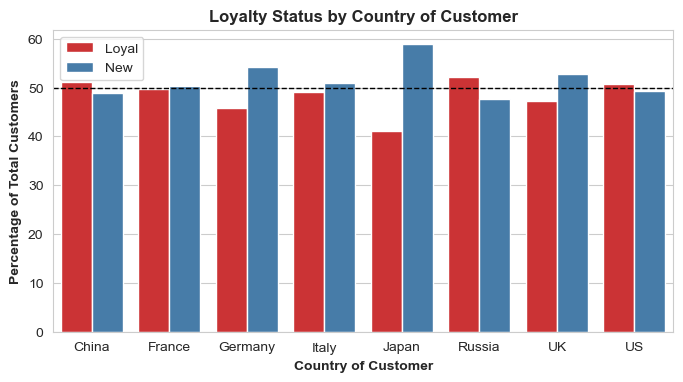

In [159]:
sns.set_style("whitegrid")
sns.set_palette('Set1')
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
sns.barplot(data=country_customer_loyalty.stack().reset_index(), x='Country_Customer', y=0, hue='Loyalty_Status_2017_Total_Omnichannel')

plt.title("Loyalty Status by Country of Customer", fontweight='bold')
ax.set_xlabel("Country of Customer", fontweight='bold')
ax.set_ylabel("Percentage of Total Customers", fontweight='bold')

# Showing 50% threshold
ax.axhline(y=50, color='black', linestyle='--', lw=1)

plt.legend()
plt.show()

* **There are no countries for which there is a noticeable unbalance between Loyal and New customers.**
* **<u>Japan</u> is the country with the highest unbalance (41% Loyal vs. 59% New)**

In [161]:
country_customer_tier = pd.crosstab(df_omni.Country_Customer, df_omni.Spending_Ranges_2017, normalize='index').apply(lambda x: np.round(x*100,2))
country_customer_tier

Spending_Ranges_2017,High,Low,Medium,Top Clients,Very High,Very Low
Country_Customer,,,,,,
China,22.11,15.19,44.66,1.49,9.46,7.09
France,21.41,20.22,34.92,1.21,8.64,13.59
Germany,18.15,24.80,40.30,0.15,2.25,14.36
Italy,21.00,22.07,34.84,1.19,8.17,12.73
Japan,4.96,41.94,21.57,0.25,1.59,29.70
Russia,25.42,15.22,36.94,2.04,11.50,8.88
UK,18.97,22.74,32.12,0.97,6.95,18.26
US,21.48,25.89,29.40,0.73,8.75,13.74


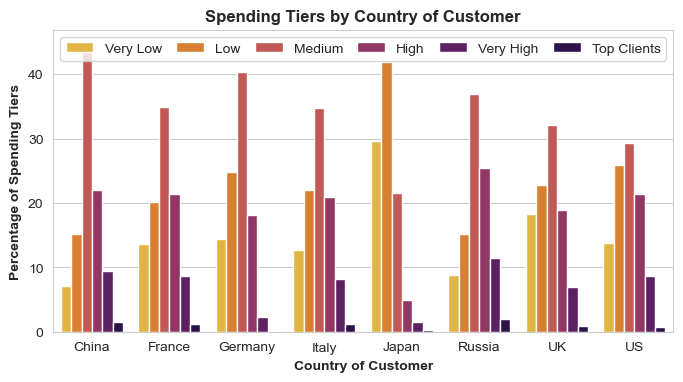

In [226]:
sns.set_style("whitegrid")
sns.set_palette(reversed(sns.color_palette("inferno")), 6)
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
sns.barplot(data=country_customer_tier[asc_labels].stack().reset_index(), x='Country_Customer', y=0, hue='Spending_Ranges_2017')

plt.title("Spending Tiers by Country of Customer", fontweight='bold')
ax.set_xlabel("Country of Customer", fontweight='bold')
ax.set_ylabel("Percentage of Spending Tiers", fontweight='bold')

# Showing 50% threshold
#ax.axhline(y=50, color='black', linestyle='--', lw=1)
ax.legend(mode='expand', ncol=6)

plt.show()

In [224]:
loyalty_tiers = pd.crosstab(df_omni.Loyalty_Status_2017_Total_Omnichannel, df_omni.Spending_Ranges_2017, normalize='columns').apply(lambda x: np.round(x*100,2))
loyalty_tiers

Spending_Ranges_2017,High,Low,Medium,Top Clients,Very High,Very Low
Loyalty_Status_2017_Total_Omnichannel,,,,,,
Loyal,63.74,40.42,45.92,69.66,64.95,39.85
New,36.26,59.58,54.08,30.34,35.05,60.15


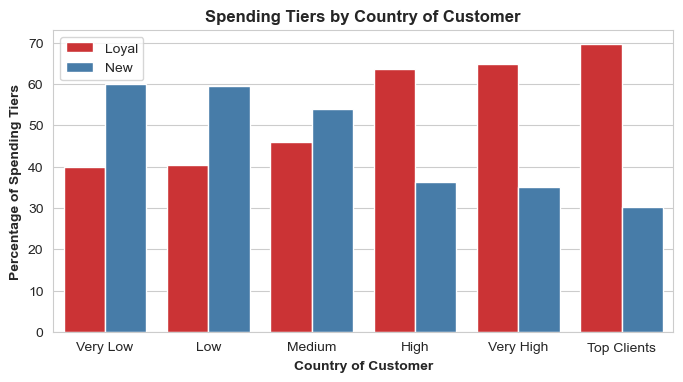

In [227]:
sns.set_style("whitegrid")
sns.set_palette('Set1')
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
sns.barplot(data=loyalty_tiers[asc_labels].stack().reset_index(), x='Spending_Ranges_2017', y=0, hue='Loyalty_Status_2017_Total_Omnichannel')

plt.title("Spending Tiers by Country of Customer", fontweight='bold')
ax.set_xlabel("Country of Customer", fontweight='bold')
ax.set_ylabel("Percentage of Spending Tiers", fontweight='bold')

ax.legend()

plt.show()

### Domestic Foreign vs. Loyalty

In [287]:
dom_for_loyalty = pd.crosstab(df_omni.Domestic_Foreign, df_omni.Loyalty_Status_2017_Total_Omnichannel, normalize='index').apply(lambda x: np.round(x*100,2))
dom_for_loyalty

Loyalty_Status_2017_Total_Omnichannel,Loyal,New
Domestic_Foreign,,
Domestic,48.39,51.61
Foreign,47.36,52.64


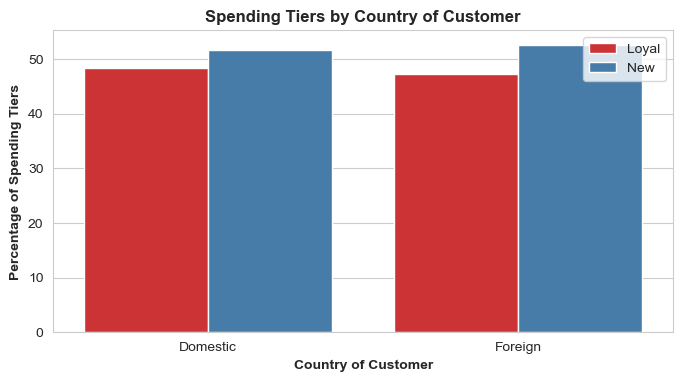

In [288]:
sns.set_style("whitegrid")
sns.set_palette('Set1')
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
sns.barplot(data=dom_for_loyalty.stack().reset_index(), x='Domestic_Foreign', y=0, hue='Loyalty_Status_2017_Total_Omnichannel')

plt.title("Spending Tiers by Country of Customer", fontweight='bold')
ax.set_xlabel("Country of Customer", fontweight='bold')
ax.set_ylabel("Percentage of Spending Tiers", fontweight='bold')

ax.legend()
plt.show()

### Retention Rate (RR) Analysis
**It measures the capability to make our clients loyal and to retain them. The higher, the better.<br>
Customers who bought during the year of the analysis over customers who bought during the year plus lost customers.**

$$
\begin{equation} Retention\ Rate =  \frac {Retained\ Customers} {Retained\ Customers + Lost\ Customer}
\end{equation}
$$

In [304]:
RR = np.round((df.Loyalty_Status_2018_Total_Omnichannel!='Lost').sum() / df.shape[0] * 100, 2)
print(f"Retention Rate between 2017 and 2018: {RR} %")

Retention Rate between 2017 and 2018: 24.7 %


#### **How to interpret this retention rate?**

In [317]:
get_stats(df_omni, 'Loyalty_Status_2017_Total_Omnichannel', 'Sales_2017_Total_Omnichannel', order=False, outlier=True, n_std=3)

,Loyalty_Status_2017_Total_Omnichannel,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Omnichannel,Outlier_Count,Outlier_Perc
0,New,50.47,24492,5,669,272,55405,16404320,37.66,361,1.47
1,Loyal,49.53,24034,5,1129,435,81450,27157746,62.34,425,1.77


* We have no information on new customers of 2018.
* We know that in 2017, almost exactly <b><u>50%</u></b> (24,492) of total customers were newly acquired customers and that they accounted for <b><u>38%</u></b> (16.4 million) of total revenue for the year.
* The <b><u>62%</u></b> (27.1 million) of the revenue in 2017 was generated by Loyal customers.
* In 2018, Loyal customers generated only <b><u>4.1</u></b> million.
* In order to keep the revenue constant from 2017 to 2018, the company would have needed <b><u>39.4</u></b> millions generated from new customers (assuming all other conditions equal).
* Assuming that the average spending for new customers remained the same in 2018, the company would have needed <b><u>59</u></b> thousands new customers.

**We can conclude that the retention rate of 24.7% is indeed a serious issue for the company.**<br>
Retaining only 1/4 of the customers surely had a negative impact on the company revenues in 2018.

#### **Which actions should be taken?**

In [94]:
mask_returned = df.Sales_2018_Total_Omnichannel.notna()
lost_customers = df_omni[mask_returned].groupby('Spending_Ranges_2017')['ID'].count().to_frame().loc[desc_labels,:].rename(columns={'ID':'Total_2018'}).reset_index()
lost_customers['Total_2017'] = df_omni.groupby('Spending_Ranges_2017')['ID'].count().to_frame().loc[desc_labels,:].values
lost_customers['Absolute_Diff'] = lost_customers['Total_2017'] - lost_customers['Total_2018']
lost_customers['Perc_Diff'] = np.round((lost_customers['Absolute_Diff'] / lost_customers['Total_2017'])*100, 2)
lost_customers.rename(columns={'Spending_Ranges_2017':'Spending_Ranges'}, inplace=True)
lost_customers

,Spending_Ranges,Total_2018,Total_2017,Absolute_Diff,Perc_Diff
0,Top Clients,150,557,407,73.07
1,Very High,948,3974,3026,76.14
2,High,2440,10136,7696,75.93
3,Medium,4104,17339,13235,76.33
4,Low,2685,10315,7630,73.97
5,Very Low,1658,6205,4547,73.28


* We can see that the lost customers are distributed evenly amongst the spending tiers.
* However Top Clients accounted for <b><u>21.7</u></b> % of the total revenue.

Our recommendation would be to invest heavily in a **Loyalty Program** targeted at Top Clients and an even more targeted action towards the "Stellar" Customers, that can be in the excel sheets attached named "stellar_clients_omni".
Out of the company's top 15 customers, 10 were lost in 2018. We recommend to investigate directly the reason with those 10 lost.

We recommend to heavily fidelize the top customers for each store, proposing customized shopping experience if they return and trying to establish a deeper connection with them.
The ID of those important customers can be found in the excel sheets named respectively:
- For the stores in France, top_clients_store_fr.xslx
- For the stores in Italy, top_clients_store_it.xslx
- For the store in the US, top_clients_store_us.xslx
- For the store in China, top_clients_store_ch.xslx

In [319]:
print(f"Avg sale of 2017: {df.Sales_2017_Total_Omnichannel.mean():0.0f}")
print(f"Avg sale of 2018: {df.Sales_2018_Total_Omnichannel.mean():0.0f}")
print(f"Total sales of 2017: {df.Sales_2017_Total_Omnichannel.sum():0.0f}")
print(f"Total sales of 2018: {df.Sales_2018_Total_Omnichannel.sum():0.0f}")
print(f"New customers of 2017: {df[df.Loyalty_Status_2017_Total_Omnichannel=='New'].shape[0]:0.0f}")
print(f"Revenue difference from 2017 to 2018: {df.Sales_2017_Total_Omnichannel.sum() - df.Sales_2018_Total_Omnichannel.sum():0.0f}")

Avg sale of 2017: 898
Avg sale of 2018: 346
Total sales of 2017: 43562067
Total sales of 2018: 4145767
New customers of 2017: 24492
Revenue difference from 2017 to 2018: 39416300


### Spending Omnichannel, by Country - 2017

In [79]:
country_stats_omni = get_stats(edited_df, 'Country_Store', 'Sales_2017_Total_Omnichannel', n_std=6)
country_stats_omni

,Country_Store,Percentage,Count,Sales_Min,Sales_Average,Sales_Max,Sales_Total,Sales_Perc_of_Omnichannel,Outlier_Count,Outlier_Perc
0,France,28.54,11581,5,1013,74290,11736677,30.20,54,0.47
1,Italy,27.46,11143,5,964,81450,10744773,27.65,60,0.54
2,US,23.21,9415,6,867,49671,8164062,21.01,53,0.56
3,China,20.79,8434,6,974,70225,8216444,21.14,44,0.52


In [77]:
top_clients_store_fr = n_outl(df_omni[df_omni["Country_Store"]=="France"], 'Sales_2017_Total_Omnichannel', n_std=6, detect=True)
top_clients_store_it = n_outl(df_omni[df_omni["Country_Store"]=="Italy"], 'Sales_2017_Total_Omnichannel', n_std=6, detect=True)
top_clients_store_us = n_outl(df_omni[df_omni["Country_Store"]=="US"], 'Sales_2017_Total_Omnichannel', n_std=6, detect=True)
top_clients_store_ch = n_outl(df_omni[df_omni["Country_Store"]=="China"], 'Sales_2017_Total_Omnichannel', n_std=6, detect=True)

### Segmentation 2018 Omnichannel

In [92]:
df_omni_18 = ranges(df[df['Sales_2018_Total_Omnichannel'].notna()], 'Sales_2018_Total_Omnichannel', 'Spending_Ranges_2018', tuples, last_label)
stats_omni_18 = get_stats(df_omni_18, 'Spending_Ranges_2018', 'Sales_2018_Total_Omnichannel', order=True, n_std=3)
stats_omni_18

,Spending_Ranges_2018,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Omnichannel,Outlier_Count,Outlier_Perc
,,,,,,,,,,,
0,Very Low,14.95,1792,1,39,39,79,70446,1.70,0,0.00
1,Low,23.08,2766,80,139,140,199,386796,9.33,0,0.00
2,Medium,57.30,6868,200,350,349,598,2404236,57.99,0,0.00
3,High,2.96,355,600,1089,1007,1996,386947,9.33,0,0.00
4,Very High,1.57,188,2015,3831,3113,9865,720268,17.37,2,1.06
6,Top Clients,0.13,16,10113,11067,11084,11841,177074,4.27,0,0.00


### Spending Evolution

In [96]:
spending_evolution = np.round(pd.crosstab(df_omni_18.Spending_Ranges_2018, df_omni[mask_returned].Spending_Ranges_2017,normalize=True)\
                        .loc[desc_labels,desc_labels] * 100,2)
spending_evolution

Spending_Ranges_2017,Top Clients,Very High,High,Medium,Low,Very Low
Spending_Ranges_2018,,,,,,
Top Clients,0.00,0.10,0.00,0.01,0.01,0.02
Very High,0.01,0.65,0.11,0.23,0.39,0.18
High,0.02,0.96,0.19,0.84,0.68,0.27
Medium,0.83,3.83,12.07,20.09,12.55,7.93
Low,0.26,1.52,4.91,8.09,5.05,3.25
Very Low,0.14,0.85,3.07,4.98,3.72,2.19


In [100]:
def Sum(mat, r, c): 
  
    i, j = 0, 0; 
    upper_sum = 0; 
    lower_sum = 0; 
      
    # to calculate sum of upper triangle 
    for i in range(r): 
        for j in range(c): 
            if (i < j): 
                upper_sum += mat[i][j]; 
  
    print("Upper sum is ", upper_sum); 
      
    # to calculate sum of lower 
    for i in range(r): 
        for j in range(c): 
            if (j < i): 
                lower_sum += mat[i][j]; 
  
    print("Lower sum is ", lower_sum);

In [101]:
Sum(spending_evolution.values, spending_evolution.shape[0], spending_evolution.shape[1])

Upper sum is  26.57
Lower sum is  45.260000000000005


**The picture represented by the Spending Evolution is quite problematic:**
* **Apart from Low and Very Low spending tiers, the percentage of customers moving to a lower spending range is always higher.**
* **Particularly, the percentage of customers moving <u>to a lower spending range</u> is <u>45</u>%, while the ones moving <u>to a higher spending range</u> is <u>26</u>%**

In [286]:
loyalty_lost = df_omni[~mask_returned].groupby('Loyalty_Status_2017_Total_Omnichannel')['ID'].count().to_frame().rename(columns={'ID':'Total_Lost_2018'}).reset_index()
loyalty_lost['Lost_Percentage'] = np.round(loyalty_lost['Total_Lost_2018'] / loyalty_lost['Total_Lost_2018'].sum() * 100, 2)
loyalty_lost

,Loyalty_Status_2017_Total_Omnichannel,Total_Lost_2018,Lost_Percentage
0,Loyal,21417,58.61
1,New,15124,41.39


### Complaints Analysis

The CEO of Max Performance Company noticed that customer complaints are not well managed by the company. As a solution he wants to implement a chatbot in the corporate website.
Please provide the CEO data and insights on complaint topic. Based on a data driven point of view, do you support the CEO proposal of implementing a chatbot? 
Please explain and support your recommendation.

In [375]:
complaint_mask = df_omni['Complaint'].notna()
complaints = df_omni[complaint_mask]
print(f"There were {complaints.shape[0]} total complaints in 2017, {(complaints.shape[0]/df_omni.shape[0])*100:0.2f} % of the customers complained.\n")
print(f"There were {complaints[complaints.Complaint_Channel=='Complaint in Boutique'].shape[0]} Botique complaints in 2017, {(complaints[complaints.Complaint_Channel=='Complaint in Boutique'].shape[0]/df_omni.shape[0])*100:0.2f} % of the customers complained through this channel.")
print(f"There were {complaints[complaints.Complaint_Channel=='Online Complaint'].shape[0]} Botique complaints in 2017, {(complaints[complaints.Complaint_Channel=='Online Complaint'].shape[0]/df_omni.shape[0])*100:0.2f} % of the customers complained through this channel.")

There were 4806 total complaints in 2017, 9.90 % of the customers complained.

There were 4069 Botique complaints in 2017, 8.39 % of the customers complained through this channel.
There were 737 Botique complaints in 2017, 1.52 % of the customers complained through this channel.


In [364]:
complaint_tiers = complaints.groupby('Spending_Ranges_2017')['ID'].count().to_frame().rename(columns={'ID':'Count'}).reset_index()
complaint_tiers['Total_2017'] =  df_omni.groupby('Spending_Ranges_2017')['ID'].count().values
complaint_tiers['Percentage'] = np.round((complaint_tiers['Count'] / complaint_tiers['Total_2017'])*100, 2)
complaint_tiers = complaint_tiers.set_index('Spending_Ranges_2017').loc[asc_labels,:].reset_index()
complaint_tiers

,Spending_Ranges_2017,Count,Total_2017,Percentage
0,Very Low,730,6205,11.76
1,Low,1118,10315,10.84
2,Medium,1786,17339,10.30
3,High,808,10136,7.97
4,Very High,309,3974,7.78
5,Top Clients,55,557,9.87


In [366]:
describe_col(complaints, 'Complaint_Channel')

Complaint_Channel - 2 unique values.
dtype: object.
No missing values.

                       Percentage %  Count
Complaint in Boutique     84.665002   4069
Online Complaint          15.334998    737


In [369]:
describe_col(complaints, 'Complaint_Reason')

Complaint_Reason - 4 unique values.
dtype: object.
No missing values.

                                    Percentage %  Count
Defect                                 44.319600   2130
Washing issue                          30.690803   1475
Delivered too late (e-Commerce)        14.898044    716
Non compliant product (e-Commerce)     10.091552    485


In [392]:
describe_col(complaints, 'Loyalty_Status_2018_Total_Omnichannel')

Loyalty_Status_2018_Total_Omnichannel - 2 unique values.
dtype: object.
No missing values.

       Percentage %  Count
Lost      75.821889   3644
Loyal     24.178111   1162


In [397]:
np.round(pd.crosstab(complaints.Loyalty_Status_2018_Total_Omnichannel, complaints.Spending_Ranges_2017, normalize='index')[desc_labels]*100, 2)

Spending_Ranges_2017,Top Clients,Very High,High,Medium,Low,Very Low
Loyalty_Status_2018_Total_Omnichannel,,,,,,
Lost,1.21,6.97,17.37,37.10,22.67,14.68
Loyal,0.95,4.73,15.06,37.35,25.13,16.78


In [371]:
pd.crosstab(complaints.Complaint_Reason, complaints.Spending_Ranges_2017)[desc_labels]

Spending_Ranges_2017,Top Clients,Very High,High,Medium,Low,Very Low
Complaint_Reason,,,,,,
Defect,27,137,353,794,470,349
Delivered too late (e-Commerce),10,42,122,267,179,96
Non compliant product (e-Commerce),5,30,84,167,110,89
Washing issue,13,100,249,558,359,196


In [372]:
pd.crosstab(complaints.Complaint_Channel, complaints.Spending_Ranges_2017)[desc_labels]

Spending_Ranges_2017,Top Clients,Very High,High,Medium,Low,Very Low
Complaint_Channel,,,,,,
Complaint in Boutique,47,270,688,1500,949,615
Online Complaint,8,39,120,286,169,115


In [387]:
pd.crosstab(complaints.Complaint_Channel, complaints.Complaint_Reason)

Complaint_Reason,Defect,Delivered too late (e-Commerce),Non compliant product (e-Commerce),Washing issue
Complaint_Channel,,,,
Complaint in Boutique,1814,589,408,1258
Online Complaint,316,127,77,217


In [384]:
get_stats(df_omni, 'Complaint_Channel', 'Sales_2017_Total_Omnichannel')

,Complaint_Channel,Percentage,Count,Sales_Min,Sales_Average,Sales_Median,Sales_Max,Sales_Total,Sales_Perc_of_Omnichannel,Outlier_Count,Outlier_Perc
0,Complaint in Boutique,84.67,4069,5,797,284,48889,3245039,86.28,85,2.09
1,Online Complaint,15.33,737,13,700,285,17995,516104,13.72,20,2.71


In [385]:
np.round((get_stats(df_omni, 'Complaint_Channel', 'Sales_2017_Total_Omnichannel')['Sales_Total'] / df_omni.Sales_2017_Total_Omnichannel.sum()) * 100,2)

0    7.45
1    1.18
Name: Sales_Total, dtype: float64

#### **Recommendations**

**We would adivise <u>against</u> the investment in a chatbot to handle complaints.**

* Only 737 (<u><b>15</b></u> % of total complains) complains were made through the Online channel, the only ones that would be addressed with a chatbot.

* The Online complaints represent only the <u><b>1.52</b></u> % of the total customer base and <u><b>1.18</b></u> % of the total revenue.
* The complains in Botique, however, represent <u><b>8.39</b></u> % of the total customer base and <u><b>7.45</b></u> % of the total revenue.

* To better tackle the complaints issue, we recommend investments to reduce the amount of Defects in the products, since they affect Top Clients and are the major cause of complaints in general.
* Defect and Washing Issue account respectively for <u><b>44</b></u> % and <u><b>30</b></u> % of all complaints. Investing towards resolving the root causes of those complaints is surely a better allocation of resources than investing in a chatbot to handle an almost irrelevant amount of complaints number-wise and revenue-wise.
* In Botiques, we'd advise to train some personnel to handle professionally the complaints, since they are a <b>serious</b> issue and <u><b>75.82</b></u> % of the customers that complained in 2017 were lost in 2018.


